# Линии тока
В этом ноутбуке будем рисовать линии тока различных течений.

Нам потребуются библиотеки `numpy`, `scipy`, `matpolib`.

1. NumPy https://numpy.org/ -- многомерные массивы и операции с ними
2. SymPy https://sympy.org/ -- библиотека для символьных вычислений
3. Matplotlib https://matplotlib.org/ -- рисуем графики

## Определение линий тока

Линией тока называется линия на плоскости или пространсве, в каждой точке параллельная вектору скорости. 

Формальное определение выглядит так. 
Пусть в трехмерном пространстве задано поле скоростей в виде векторного поля
$$
\vec{v}(x,y,z) = (v_x(x,y,z), v_y(x,y,z), v_z(x,y,z)),
$$
тогда линия 
$$
x=x(s),\quad 
y=y(s),\quad
z=z(s),
$$
проходящая через точку в пространстве $(x_0, y_0, z_0)$, является векторной линией, если она удовлетворяет следующей системе обыкновенных дифференциальных уравнений
$$
\begin{array}{ccc}
\displaystyle\frac{dx}{ds} & = & v_x(x(s), y(s), z(s)), \\
\displaystyle\frac{dy}{ds} & = & v_y(x(s), y(s), z(s)), \\
\displaystyle\frac{dz}{ds} & = & v_z(x(s), y(s), z(s)), 
\end{array}
$$
при начальных условиях 
$$
x|_{s=0} = x_0,\quad
y|_{s=0} = y_0,\quad
z|_{s=0} = z_0.
$$

Иначе эту систему уравнений можно переписать в дифференциалах
$$
\frac{dx}{v_x(x,y,z)}=\frac{dy}{v_y(x,y,z)}=\frac{dz}{v_z(x,y,z)}.
$$

Для построения линий тока аналитически удобно использовать определение в дифференциалах, а для построения на компьютере интегрировать задачу Коши для системы обыкновенных дифференциальных уравнений.

Напишем решатель этой системы уравнений, используя метод Рунге-Кутты (https://ru.wikipedia.org/wiki/Метод_Рунге_—_Кутты).

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

Рассмотрим поле течения 
$$\vec{v}(x,y) = (v_x(x,y), v_y(x,y))$$
вида
$$
\begin{array}{lc}
v_x(x,y) = \displaystyle\frac{y}{\sqrt{x^2+y^2}},\\
v_y(x,y) = -\displaystyle\frac{x}{\sqrt{x^2+y^2}}.
\end{array}
$$

Удобно задать выражения этих скоростей в символьном виде, т.к. в дальнейшем может потребоваться выполнить их преобразования. С помощью пакета `sympy` это делается следующим образом. Сначала необходимо определить, какие переменные будут использоваться как символы и ввести их обозначения. В следующем примере мы создаем четыре символа `x`, `y`, `vx`, `vy`.

In [2]:
x, y = sp.symbols('x y')
vx, vy = sp.symbols('v_x v_y')
display(x, y, vx, vy)

x

y

v_x

v_y

Зададим для них связь по указанным формулам (`sp.sqrt` специальная функция квадратного корня для символьных выражений)

In [3]:
vx = y/sp.sqrt(x**2+y**2)
vy = -x/sp.sqrt(x**2+y**2)
display(vx, vy)

y/sqrt(x**2 + y**2)

-x/sqrt(x**2 + y**2)

Теперь мы можем выполнять с ними, если потребуется, любые символьные выражения. Например, найти сумму

In [4]:
(vx+vy).simplify()

(-x + y)/sqrt(x**2 + y**2)

или можно взять производную от `vx` по переменной `x`

In [5]:
vx.diff(x)

-x*y/(x**2 + y**2)**(3/2)

Для того, чтобы их быстро вычислять в заданных точках, получим питоновские функции от аргументов `(x,y)` с помощью функции `sp.lambdify`

In [6]:
vxf = sp.lambdify((x, y), vx) 
vyf = sp.lambdify((x, y), vy) 

Теперь можно легко посчитать значение $v_x$ и $v_y$ в любой заданной точке, например, $v_x(1,1)$:

In [7]:
vxf(1,1)

np.float64(0.7071067811865475)

В качестве аргументов можно также использовать `numpy` массивы. 

В следующем примере мы посчитаем за один проход значение функции $v_y(x,y)$ в точках $(1,2)$, $(2,3)$.

In [8]:
x0 = np.array([1, 2])
y0 = np.array([2, 3])
vyf(x0, y0)

array([-0.4472136, -0.5547002])

Можно объединить точки в один двумерный массив

In [9]:
points = np.array(
    [[1,2],
     [2,3]]
)

Тогда синтаксис расчета будет следующим

In [10]:
vyf(points[:,0], points[:, 1])

array([-0.4472136, -0.5547002])

Выражение `points[:,0]` означает, что мы берем все значения по первому измерению, а по второму только нулевую компоненту.

Выражение `points[:,1]` означает, что мы берем все значения по первому измерению, а по второму только первую компоненту.

## Математическая постановка задачи и численный решатель

Для построения линий тока реализуем решатель 4-го порядка на основе метода Рунге-Кутта (https://ru.wikipedia.org/wiki/Метод_Рунге_—_Кутты).

Для системы дифференциальных уравнений 
$$
\frac{d\mathbf{r}}{ds} = \mathbf{f}(\mathbf{r}),\quad
\mathbf{r}|_{s=0} = \mathbf{r}_0,
$$
где
$$
\mathbf{r}(s) = (x(s), y(s), z(s)),\quad
\mathbf{r}_0 = (x_0, y_0, z_0),
$$
он имеет следующий вид
$$
\mathbf{r}_{n+1} = \mathbf{r}_n + \frac{h}{6}\left(
\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4
\right),
$$
где 
$$
\begin{array}{ccl}
\mathbf{k}_1 & = & \mathbf{f}(\mathbf{r}_n), \\
\mathbf{k}_2 & = & \mathbf{f}(\mathbf{r}_n + \frac{h}{2}\mathbf{k}_1), \\
\mathbf{k}_3 & = & \mathbf{f}(\mathbf{r}_n + \frac{h}{2}\mathbf{k}_2), \\
\mathbf{k}_4 & = & \mathbf{f}(\mathbf{r}_n + h\mathbf{k}_3),
\end{array}
$$
где $h$ -- шаг по переменной $s$.

Здесь $\mathbf{r}_0$ -- начальная точка, из которой будет строиться линия тока. На основании численного алгоритма будем получать приблизительные точки траектории линии тока $\mathbf{r}_1$, $\mathbf{r}_2$, $\ldots$ итерационным методом по указанным формулам с шагом интегрирования $h$.

## Алгоритм построения линий тока (2D)
1. Генерируем начальные точки в виде `np.ndarray` размерности `[n_points, 2]`, где `n_points` -- количество точек. 
2. Путем итеративного процесса для каждой из точек с помощью метода Рунге-Кутты получим точки лежащие на линиях тока

В результате у нас получиться трехмерный массив вида `[n_steps+1, n_points, 2]`, где `n_steps` -- количество точек на траекториях, полученные в результате интегрирования.

Будем отображать их с помощью библиотеки `matplotlib`.

In [11]:
from collections.abc import Callable

class StreamLine:
    """Класс Streamline для генерации линий тока вдоль заданного поля течения
    """
    def __init__(self, vx : Callable, vy : Callable) -> None:
        """ Конструктор
            @param vx  x компонента вектора скорости в виде функции, задающей отображение (x,y) -> vx
            @param vy  y компонента вектора скорости в виде функции, задающей отображение (x,y) -> vy
        """  
        self.vx = vx
        self.vy = vy

    def f(self, r : np.ndarray) -> np.ndarray: 
        """ Правая часть системы обыкновенных дифференциальных уравнений для вычисления линий тока
            @param r Координаты точек, [n_points, 2]
            @return  Значение правой части f(r), [n_points, 2]
        """
        return np.dstack([self.vx(r[:, 0], r[:, 1]),  self.vy(r[:, 0], r[:, 1])]).squeeze() 

    def RK4(self, h : float, rn : np.ndarray) -> np.ndarray:
        """ Шаг метода Рунге-Кутты 4-го порядка
            @param h    Величина шага
            @param rn   Координаты точек, [n_points, 2] 
            @return     Результат численного интегрирования, [n_points, 2]
        
        """
        k1 = self.f(rn)
        k2 = self.f(rn + h*k1/2)
        k3 = self.f(rn + h*k2/2)
        k4 = self.f(rn + h*k3)

        return rn + h*(k1+2*k2+2*k3+k4)/6

    def generate(self, h : float, r0 : np.ndarray, num_steps : int = 10) -> np.ndarray:
        """ Генерация точек вдоль линиий тока
            @param h           Шаг интегрирования
            @param r0          Начальные координаты точек,  [n_points, 2]
            @params num_steps  Количество шагов интегрирования
            @return            Облако точек, [num_steps+1, n_points, 2]
        """

        streamlines = np.expand_dims(r0, axis=0)

        for _ in range(num_steps):
            streamlines = np.concatenate([
                streamlines, np.expand_dims(self.RK4(h, streamlines[-1,:,:]), axis=0)
            ])

        return streamlines            

In [12]:
# Создаем объект с заранее заданным полем течения vx, vy
sl = StreamLine(vxf, vyf)

In [42]:
# Создаем начальные точки, из которых выпускаем линии тока
ry = np.arange(0.01, 1, 0.1)
rx = np.zeros_like(ry)
r = np.dstack((rx, ry)).squeeze()

In [43]:
# Генерируем наборы точек вдоль траекторий
pts = sl.generate(0.01, r, 1000)

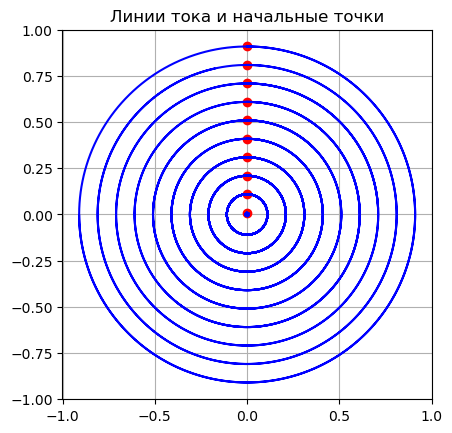

In [44]:
# Отображаем траектории и начальные точки
fig, ax = plt.subplots()

ax.set_title("Линии тока и начальные точки")
ax.plot(rx, ry, 'ro')
ax.plot(pts[:, :, 0], pts[:, :, 1], 'b')
ax.set_aspect('equal', 'box')
ax.grid(True)

Исследуя получившиеся линии тока, можно предположить, что наше течение представляет собой вихрь, закручивающий сплошную среду на плоскости по часовой стрелке. Но такой вывод можно строго обосновать, только проанализировав аналитические формулы. 

Изучите влияние шага интегрирования на получаемые линии тока. 

*Ваш текст с графиками, подтверждающие ваши утверждения*

## Задания

Построить линии тока для следующих полей течений

1. (*10 баллов*) Тип течения -- источник
    $$
    v_x(x,y) = \frac{x}{\sqrt{x^2+y^2}},\quad
    v_y(x,y) = \frac{y}{\sqrt{x^2+y^2}}.
    $$

2. (*20 баллов*) Тип течения -- диполь. Пусть $w(z) = 1/z$, где $z = x + i y \in C$ -- комплексное, тогда
    $$
    v_x(x,y) = Re\left[\frac{dw}{dz}\right],\quad
    v_y(x,y) = -Im\left[\frac{dw}{dz}\right].
    $$

3. (*30 баллов*) Обтекание покоящейся сферы идеальной жидкостью. В сферических координатах ($r$, $\theta$) в плоскости, проходящей через ось симметрии, поле течения имеет вид

   $$
        v_r(r,\theta) = V \left(1-\frac{R^3}{r^3}\right)\cos\theta,\quad
        v_{\theta}(r,\theta) = -V\left( 1 + \frac{R^3}{2r^3} \right)\sin\theta,
   $$

   $$
        r \geq R,\quad 0 \leq \theta \leq \pi,
   $$
    где $V$ -- скорость жидкости на бесконечности, $R$ -- радиус сферы, $r$ -- расстояние до начала координат, $\theta$ -- зенитный угол.

4. (*30 баллов*) Обтекание покоящейся сферы вязкой жидкостью при малых числах Рейнольдса. В сферических координатах ($r$, $\theta$) в плоскости, проходящей через ось симметрии,  поле течения имеет вид

   $$
        v_r(r,\theta) = V \left(1 - \frac{3}{2}\frac{R}{r} + \frac{1}{2}\frac{R^3}{r^3}  \right)\cos\theta,\quad
        v_{\theta}(r,\theta) = -V\left( 1 - \frac{3}{4}\frac{R}{r} - \frac{1}{4} \frac{R^3}{r^3} \right)\sin\theta,
   $$

   $$
        r \geq R,\quad 0 \leq \theta \leq \pi,
   $$
    где $V$ -- скорость жидкости на бесконечности, $R$ -- радиус сферы, $r$ -- расстояние до начала координат, $\theta$ -- зенитный угол.


### Дополнительно

Что ещё можно сделать или улучшить.
1. Реализовать адаптивный решатель Рунге-Кутты для автоматической подстройки шага интегрирования
2. Реализовать расчёт и отображение трехмерных линий тока
3. Реализовать отображение направление течения в виде стрелок